In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import make_scorer
from pandas.api.types import CategoricalDtype
from time import perf_counter
from xgboost import XGBRegressor


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [2]:
%matplotlib inline
sns.set_theme()

## Loding Data

Load the full car datset. Keep only a subset of columns useful for prediction.
Drop samples with key features missing (mileage, age, price, power). Split the df in train and test. 

In [3]:
file_path = os.path.join("data", "autoscout_dataset.csv")
df_raw = pd.read_csv(file_path, sep=";", index_col="url")

In [4]:
final_col = ['Carburante',
                 'Carrozzeria',
                 'Chilometraggio',
                 'Cilindrata_cm3',
                 'Cilindri',
                 'Colore',
                 'Consumo_comb_L100km',
                 'Consumo_extraurb_L100km',
                 'Consumo_urb_L100km',
                 'Marce',
                 'Peso_a_vuoto_kg',
                 'Tagliandi_certificati',
                 'Tipo_di_cambio',
                 'Trazione',
                 'country',
                 'makeId',
                 'maker',
                 'model',
                 'modelOrModelLineId',
                 'potenza_kw',
                 'price',
                 'unico_proprietario',
                 'zip'
            ]

In [5]:
df_raw = (df_raw.astype({'Anno':'datetime64[ns]', 'date':'datetime64[ns]'})
    .assign(age_years= lambda x: (x['date'] - x['Anno']) / np.timedelta64(1, 'Y'))
    .drop(columns=[col for col in df_raw.columns if col not in final_col])
    .dropna(subset=['price', 'potenza_kw', 'age_years', 'Chilometraggio'])
)
    

In [6]:
df_train, df_test = train_test_split(df_raw, test_size=0.1)

## Loss Functions

In [7]:
def rmse_loss(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)**0.5

def rmspe_loss(y_true, y_pred):
    return np.mean((y_true-y_pred)**2/y_true**2)**0.5

def mape_loss(y_true, y_pred):
    return np.mean(np.abs(y_true-y_pred)/y_true)

rmse = make_scorer(rmse_loss, greater_is_better=False)
mae = make_scorer(mean_absolute_error, greater_is_better=False)
rmspe = make_scorer(rmspe_loss, greater_is_better=False)
mape = make_scorer(mape_loss, greater_is_better=False)

## Baseline

In [17]:
price_mean = float(df_train['price'].mean())
price_median = float(df_train['price'].median())

rmse_mean = rmse_loss(df_test['price'].to_numpy(), np.ones(len(df_test))*price_mean)
mae_median = mean_absolute_error(df_test['price'].to_numpy(), np.ones(len(df_test))*price_median)

print(f'Baseline (mean/rms): {rmse_mean:.0f}')
print(f'Baseline (median/mae): {mae_median:.0f}')

Baseline (mean/rms): 18165
Baseline (median/mae): 10798


## Linear Models

In [9]:
lm_num_features = ['age_years', 'potenza_kw', 'Chilometraggio']
lm_cat_features = ['Tipo_di_cambio', 'Trazione', 'Carrozzeria']

In [10]:
#Numerical features pipeline
lm_num_transformer = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)


#Categorical features pipeline
lm_cat_transformer = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

# Preprocessing pipeline
lm_preprocessor = make_column_transformer(
    (lm_num_transformer, lm_num_features),
    (lm_cat_transformer, lm_cat_features),
    remainder='drop'
)


# Full model pipeline
lm_model = make_pipeline(
    lm_preprocessor,
    LinearRegression()    
)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(columns=['price']), df_train['price'], test_size=0.2, random_state=42
)

In [12]:
lm_model.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age_years', 'potenza_kw',
                                                   'Chilometraggio']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                 

In [18]:
print(f'rmse lmcat train: {rmse_loss(y_train, lm_model.predict(X_train)):.0f}')
print(f'rmse lmcat test: {rmse_loss(y_test, lm_model.predict(X_test)):.0f}')

rmse lmcat train: 18675.6
rmse lmcat test: 19299.8


In [22]:
print(f'mape lmcat train: {mape_loss(y_train, lm_model.predict(X_train))*100:.1f}')
print(f'mape lmcat test: {mape_loss(y_test, lm_model.predict(X_test))*100:.1f}')

mape lmcat train: 57.8
mape lmcat test: 55.1


(-100000.0, 100000.0)

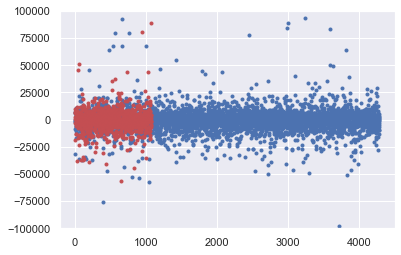

In [13]:
plt.plot((y_train-lm_model.predict(X_train)).to_numpy(), 'b.')
plt.plot((y_test-lm_model.predict(X_test)).to_numpy(), 'r.')
plt.ylim(-1e5, 1e5)

## Random Forest Model

## XGB Model

In [14]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.float_format', '{:.0f}'.format):
    display(df_raw.groupby('maker')['price'].apply(np.mean).sort_values(ascending=False).to_frame().T)

maker,Ferrari,Lamborghini,Aston Martin,Porsche,Alpine,Caterham,Austin-Healey,Lotus,Morgan,Maserati,Tesla,Cupra,Jaguar,Land Rover,RAM,Audi,Lexus,SsangYong,DR Motor,Mercedes-Benz,Volvo,DS Automobiles,Jeep,BMW,Abarth,Infiniti,Alfa Romeo,Dodge,HUMMER,Volkswagen,GMC,Subaru,MINI,Skoda,EVO,Mazda,SEAT,Toyota,Renault,Iveco,Mitsubishi,Nissan,Kia,Hyundai,Peugeot,Great Wall,Panther Westwinds,Ford,Isuzu,Citroen,Cadillac,Chevrolet,Suzuki,Fiat,smart,Honda,Opel,Dacia,MG,Mahindra,Rover,Piaggio,Lancia,Dutton,Chatenet,Aixam,Daihatsu,Chrysler,Tata,Talbot,Daewoo
price,209500,145000,141833,98694,61000,58000,57300,57000,55000,52819,44450,36190,34297,34264,34000,32976,30555,29528,29000,27678,26884,25902,25834,25186,23371,23200,21457,21150,19500,18481,18000,17952,17833,17646,16850,16801,16573,16399,16223,15954,15755,15734,15721,15573,15039,15000,15000,14873,14800,13525,13500,13199,13141,12492,12335,12121,11793,11591,10900,10450,9450,9400,9156,9000,8400,8350,6900,6700,6633,5900,1667
